# Explanation Title
--This is where the explanation will go--

In [57]:
### IMPORTS

# Standard library
import os
import json
import time
import logging
import functools
from datetime import datetime
from logging.handlers import RotatingFileHandler
import warnings

# Third-party libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import torch
from scipy.stats import genpareto, kurtosis, skew
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Local modules
from ACTIVE.V1.V1_secret import API_TOKEN

# Config
warnings.filterwarnings("ignore", category=ConvergenceWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
### LOGGING

import os, json, time, logging
from logging.handlers import RotatingFileHandler

class Config:
    LOG_DIR = "logs"
    SCR_DIR = "screenshots"

class JsonFormatter(logging.Formatter):
    """
    True JSON formatter: includes ISO-8601 timestamp, source, and supports exceptions.
    """
    def format(self, record: logging.LogRecord) -> str:
        base = {
            "time": self.formatTime(record),
            "level": record.levelname,
            "logger": record.name,
            "module": record.module,
            "func": record.funcName,
            "line": record.lineno,
            "message": record.getMessage(),
        }
        if record.exc_info:
            base["exc_info"] = self.formatException(record.exc_info)
        return json.dumps(base, ensure_ascii=False)

    def formatTime(self, record, datefmt=None):
        # ISO-8601 with milliseconds
        t = self.converter(record.created) if hasattr(self, "converter") else time.localtime(record.created)
        s = time.strftime("%Y-%m-%dT%H:%M:%S", t)
        return f"{s}.{int(record.msecs):03d}"

class Logger:
    """
    Structured JSON logging to console (INFO) + rotating file (DEBUG).
    Idempotent: calling setup() multiple times will not add duplicate handlers.
    """
    @staticmethod
    def setup(name: str = "fractal",
              log_dir: str = Config.LOG_DIR,
              max_bytes: int = 5_000_000,
              backups: int = 3,
              console_level: int = logging.INFO,
              file_level: int = logging.DEBUG) -> logging.Logger:

        os.makedirs(log_dir, exist_ok=True)
        logger = logging.getLogger(name)
        logger.setLevel(logging.DEBUG)
        logger.propagate = False  # avoid double logs via root

        # If already configured, return as-is
        if getattr(logger, "_fractal_configured", False):
            return logger

        fmt = JsonFormatter()

        # Console handler
        ch = logging.StreamHandler()
        ch.setLevel(console_level)
        ch.setFormatter(fmt)
        logger.addHandler(ch)

        # Rotating file handler
        fh = RotatingFileHandler(os.path.join(log_dir, f"{name}.log"),
                                 maxBytes=max_bytes, backupCount=backups)
        fh.setLevel(file_level)
        fh.setFormatter(fmt)
        logger.addHandler(fh)

        logger._fractal_configured = True
        return logger

def log_method(fn):
    """
    Decorator: logs entry/exit + elapsed time; captures exceptions with traceback.
    Assumes 'self.logger' exists; otherwise falls back to 'fractal' logger.
    """
    import functools, time as _time
    @functools.wraps(fn)
    def wrapper(self, *args, **kwargs):
        logger = getattr(self, "logger", logging.getLogger("fractal"))
        name = f"{self.__class__.__name__}.{fn.__name__}"
        logger.info(f"▶ Starting {name}")
        start = _time.time()
        try:
            result = fn(self, *args, **kwargs)
            elapsed = _time.time() - start
            logger.info(f"✔ Finished {name} in {elapsed:.2f}s")
            return result
        except Exception:
            elapsed = _time.time() - start
            logger.exception(f"✖ Error in {name} after {elapsed:.2f}s")
            raise
    return wrapper


In [59]:
### DATA COLLECTION AND PLOTTING

# data collection
def get_daily_data(symbol, start_date, end_date, api_token, logger):
    """
    Fetch end‑of‑day price and volume for a given symbol from the EODHD API.
    Returns a DataFrame indexed by business‑day datetime with ‘close’ and ‘volume’ columns, or an empty DataFrame on failure.
    """
    logger.info(f"Fetching data for {symbol} from {start_date} to {end_date}")
    url  = f'https://eodhd.com/api/eod/{symbol}?api_token={api_token}&from={start_date}&to={end_date}&fmt=json'
    resp = requests.get(url)
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())
        if 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'])
            df = df.set_index('datetime').asfreq('B').rename_axis(None)
            return df[['close', 'volume']]
    logger.warning(f"No data for {symbol}")
    return pd.DataFrame()

# plotting
def plot_with_quantification(data, title):
    """
    Fit and plot a linear trend on the price series, then overlay ±1 σ and ±2 σ bands on the residuals.
    Highlights points outside ±1 σ and shows a Matplotlib figure annotated with mean and residual standard deviation.
    """
    df = data.copy().reset_index().rename(columns={'index':'datetime'})
    df['day_num'] = np.arange(len(df))
    X, y = df[['day_num']].values, df['close'].values
    model = LinearRegression().fit(X, y)
    df['trend'] = model.predict(X)
    resid   = y - df['trend']
    std_res = resid.std()
    mean_p  = df['close'].mean()
    df['in_upper'] = df['close'] > (df['trend'] + std_res)
    df['in_lower'] = df['close'] < (df['trend'] - std_res)
    plt.figure(figsize=(14,7))
    plt.plot(df['datetime'], df['close'],           label='Prix')
    plt.plot(df['datetime'], df['trend'],           label='Trend')
    plt.plot(df['datetime'], df['trend'] + std_res, '--', label='+1σ')
    plt.plot(df['datetime'], df['trend'] - std_res, '--', label='-1σ')
    plt.plot(df['datetime'], df['trend'] + 2*std_res,'-.',label='+2σ')
    plt.plot(df['datetime'], df['trend'] - 2*std_res,'-.',label='-2σ')
    plt.scatter(df.loc[df['in_upper'], 'datetime'], df.loc[df['in_upper'], 'close'],
                marker='o', s=40, color='crimson', edgecolors='none', label='> +1σ')
    plt.scatter(df.loc[df['in_lower'], 'datetime'], df.loc[df['in_lower'], 'close'],
                marker='o', s=40, color='purple', edgecolors='none', label='< -1σ')
    plt.title(f"{title} • Mean: {mean_p:.2f} • σ_res: {std_res:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()

{"time": "2025-09-06T13:10:58.483", "level": "INFO", "logger": "fractal", "module": "1857483962", "func": "get_daily_data", "line": 9, "message": "Fetching data for USDJPY.FOREX from 2024-09-06 to 2025-09-06"}


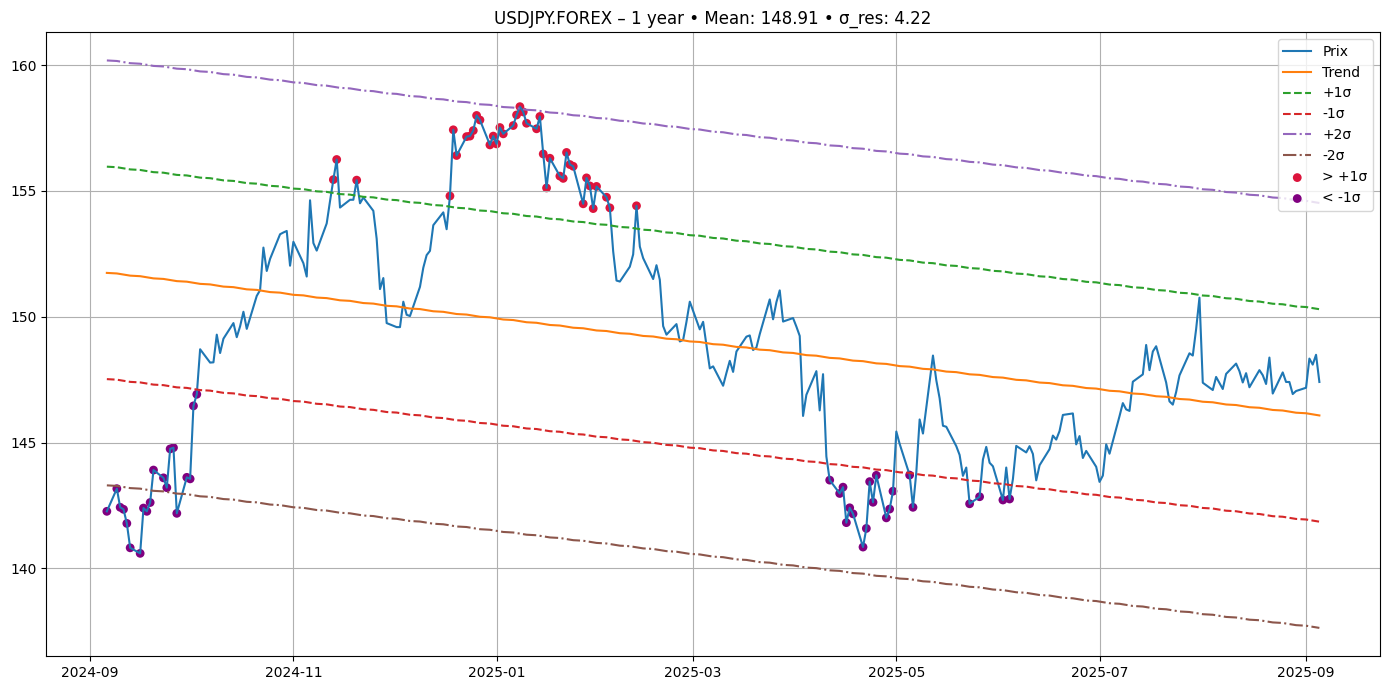

In [60]:
# TESTING PLOTTING

api_token = API_TOKEN
ticker = "USDJPY.FOREX"
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
logger = Logger.setup()

start_1y = (pd.to_datetime(end_date) - pd.DateOffset(years=1)) \
        .strftime('%Y-%m-%d')
data_1y = get_daily_data(ticker, start_1y, end_date, api_token, logger) \
        .resample('B').last().ffill()

plot_with_quantification(data_1y, f'{ticker} – 1 year')




In [61]:
# metrics + systemics
